#Data Preparation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf

In [ ]:
tickers=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol']

In [ ]:
print(tickers)

0       MMM
1       AOS
2       ABT
3      ABBV
4      ABMD
       ... 
498     YUM
499    ZBRA
500     ZBH
501    ZION
502     ZTS
Name: Symbol, Length: 503, dtype: object


In [ ]:
from sklearn.linear_model import LinearRegression
def test_it(opens,closes,preds,start_account=1000,thresh=0):
    account = start_account
    changes=[]
    
    for i in range(len(preds)):
        if(preds[i]-opens[i])/opens[i] >= thresh:
            account += account*(closes[i]-opens[i])/opens[i]
        changes.append(account)
    changes = np.array(changes)

    plt.plot(range(len(changes)),changes)
    plt.show()

    invest_total = start_account + start_account*(closes[-1]-opens[0])/opens[0]
    print('Investing Total:',invest_total,str(round((invest_total-start_account)/start_account*100,1))+ '%')
    print('Algo- trading Total:',account,str(round((account-start_account)/start_account*100,1))+ '%')

In [ ]:
#Moving Average Convergence Divergence (MACD) 
def calc_macd(data,len1,len2,len3):
    shortEMA = data.ewm(span=len1,adjust=False).mean()
    longEMA = data.ewm(span=len2,adjust=False).mean()
    MACD = shortEMA - longEMA
    signal = MACD.ewm(span=len3,adjust=False).mean()
    return MACD,signal

In [ ]:
def calc_rsi(data,period):
    delta= data.diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0) # to make positive output
    ema_up = up.ewm(com=period,adjust=False).mean() #ema is exponential moving avg
    ema_down = down.ewm(com=period,adjust=False).mean()
    rs = ema_up / ema_down
    rsi = 100 - (100/(1+rs))
    return rsi

In [ ]:
def calc_bollinger(data,period):
    mean = data.rolling(period).mean()
    std = data.rolling(period).std()
    upper_band = np.array(mean) + 2*np.array(std)
    lower_band = np.array(mean) - 2*np.array(std)
    return upper_band,lower_band

[*********************100%***********************]  1 of 1 completed
MMM


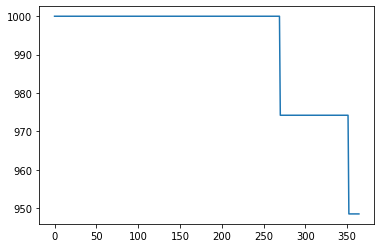

Investing Total: 741.9888314506794 -25.8%
Algo- trading Total: 948.5315735984998 -5.1%
[*********************100%***********************]  1 of 1 completed
AOS


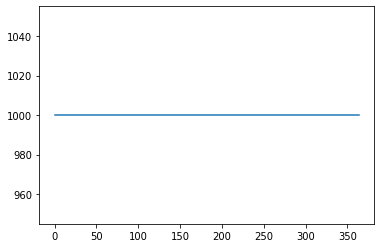

Investing Total: 989.6925203478838 -1.0%
Algo- trading Total: 1000 0.0%
[*********************100%***********************]  1 of 1 completed
ABT


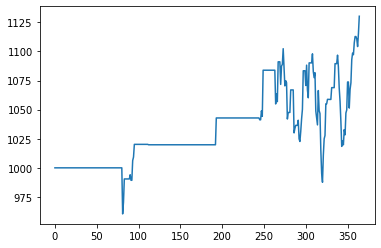

Investing Total: 908.8024188761954 -9.1%
Algo- trading Total: 1130.1965687322001 13.0%
[*********************100%***********************]  1 of 1 completed
ABBV


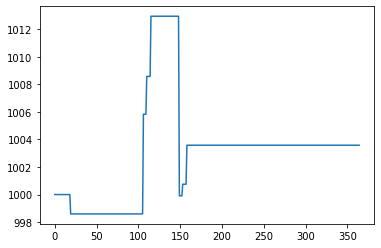

Investing Total: 1446.5160031224484 44.7%
Algo- trading Total: 1003.5794768735241 0.4%
[*********************100%***********************]  1 of 1 completed
ABMD


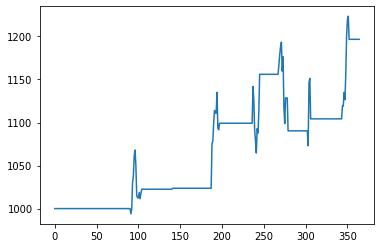

Investing Total: 817.9738960807267 -18.2%
Algo- trading Total: 1196.6712569162105 19.7%
[*********************100%***********************]  1 of 1 completed
ACN


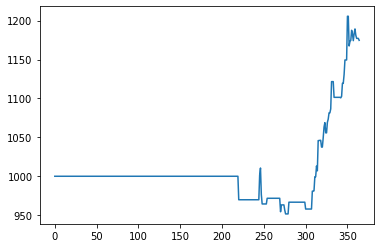

Investing Total: 1094.000509056659 9.4%
Algo- trading Total: 1174.6955909639532 17.5%
[*********************100%***********************]  1 of 1 completed
ATVI


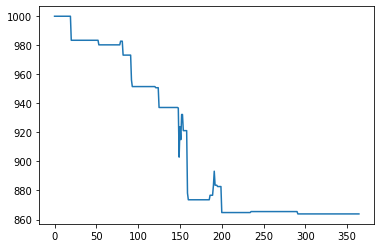

Investing Total: 824.2624336216669 -17.6%
Algo- trading Total: 863.8702491125345 -13.6%
[*********************100%***********************]  1 of 1 completed
ADM


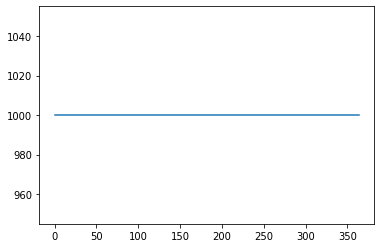

Investing Total: 1412.0415302987876 41.2%
Algo- trading Total: 1000 0.0%
[*********************100%***********************]  1 of 1 completed
ADBE


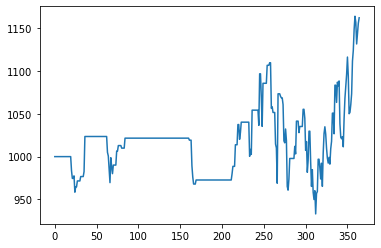

Investing Total: 779.8558545802211 -22.0%
Algo- trading Total: 1162.5262735098236 16.3%
[*********************100%***********************]  1 of 1 completed
ADP


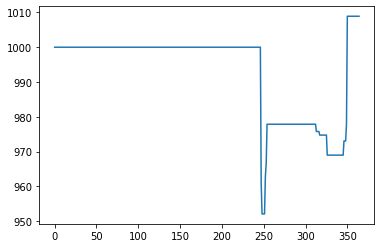

Investing Total: 1281.6783114593893 28.2%
Algo- trading Total: 1008.9094978815772 0.9%


In [ ]:
for ticker in tickers[0:10]:
    end_date = datetime.now()
    start_date = end_date - timedelta(days=15*365)

    history = yf.download(ticker,start_date,end=end_date,interval='1d',prepost=False)
    history=history.loc[:,['Open','Close','Volume']]

    history['Prev_Close']= history.loc[:,'Close'].shift(1)
    history['Prev_Volume']= history.loc[:,'Volume'].shift(1)

    datetimes=history.index.values
    weekdays=[]

    for dt in datetimes:
        #print(dt) #2007-07-23T00:00:00.000000000
        dt= datetime.strptime(str(dt),'%Y-%m-%dT%H:%M:%S.000000000')
        #print(dt)
        weekdays.append(dt.weekday())
    history['Weekday'] = weekdays

    history['5SMA'] = history['Prev_Close'].rolling(5).mean()
    history['10SMA'] = history['Prev_Close'].rolling(10).mean()
    history['20SMA'] = history['Prev_Close'].rolling(20).mean()
    history['50SMA'] = history['Prev_Close'].rolling(50).mean()
    history['100SMA'] = history['Prev_Close'].rolling(100).mean()
    history['200SMA'] = history['Prev_Close'].rolling(200).mean()
    
    MACD, signal = calc_macd(history['Prev_Close'],12,26,9)
    history['MACD']= MACD
    history['MACD_signal'] = signal

    history['RSI']=calc_rsi(history['Prev_Close'],13)
    history['RSI_Volume']=calc_rsi(history['Prev_Volume'],13)


    upper,lower=calc_bollinger(history['Prev_Close'],20)
    history['Upper_Band']=upper
    history['Lower_Band']=lower

    labels = ['Prev_Close',	'Prev_Volume',	'5SMA',	'10SMA',	'20SMA',	'50SMA',	'100SMA',	'200SMA',	'MACD',	'MACD_signal',	'RSI',	'RSI_Volume',	'Upper_Band',	'Lower_Band']
    period=1
    new_labels=[str(period)+'d_'+label for label in labels]
    #print(new_labels)
    history[new_labels]=history[labels].pct_change(period,fill_method='ffill') #percentage change

    period=2
    new_labels=[str(period)+'d_'+label for label in labels]
    #print(new_labels)
    history[new_labels]=history[labels].pct_change(period,fill_method='ffill')

    period=5
    new_labels=[str(period)+'d_'+label for label in labels]
    #print(new_labels)
    history[new_labels]=history[labels].pct_change(period,fill_method='ffill')

    period=10
    new_labels=[str(period)+'d_'+label for label in labels]
    #print(new_labels)
    history[new_labels]=history[labels].pct_change(period,fill_method='ffill')

    history=history.replace(np.inf,np.nan).dropna() #dropping the rows with nan, basically first 200 rows which do not have sma values

    y = history['Close']
    X = history.drop(['Close','Volume'],axis=1).values

    num_test = 365
    X_train = X[:-1*num_test]
    y_train = y[:-1*num_test]
    X_test = X[-1*num_test:]
    y_test = y[-1*num_test:]

    #print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

    model = LinearRegression()
    model = model.fit(X_train,y_train)
    preds = model.predict(X_test)

    print(ticker)

    test_it(X_test.T[0],y_test,preds,1000,0.005)



[*********************100%***********************]  1 of 1 completed


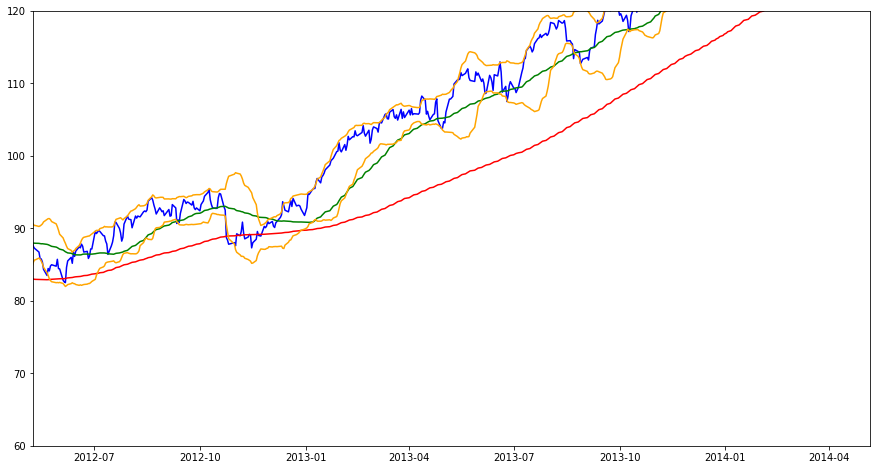

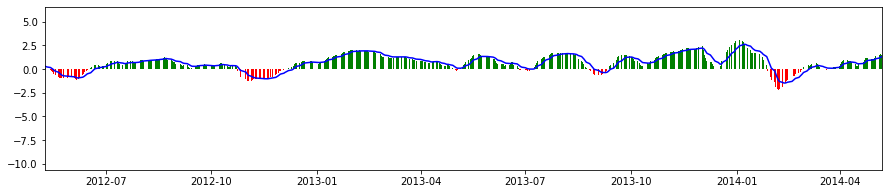

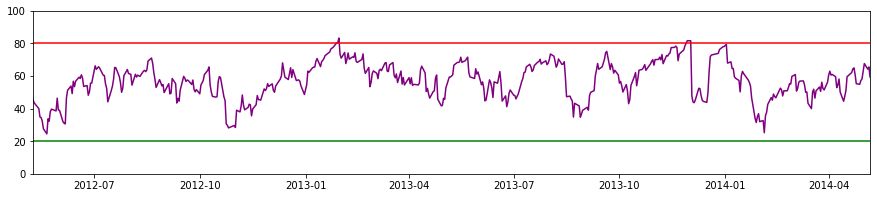

,Open,Close,Volume,Prev_Close,Prev_Volume,Weekday,5SMA,10SMA,20SMA,50SMA,...,10d_20SMA,10d_50SMA,10d_100SMA,10d_200SMA,10d_MACD,10d_MACD_signal,10d_RSI,10d_RSI_Volume,10d_Upper_Band,10d_Lower_Band
Date,,,,,,,,,,,,,,,,,,,,,
2008-05-21,77.510002,76.120003,4429800,77.529999,5215400.0,2,78.166002,77.563000,77.790000,78.863800,...,-0.017456,-0.002557,-0.010428,-0.007120,-0.398018,0.650824,0.040754,0.221373,-0.035476,0.002271
2008-05-22,76.370003,76.639999,3843200,76.120003,4429800.0,3,77.844002,77.507001,77.564500,78.827200,...,-0.018500,-0.001856,-0.010353,-0.006975,-0.295249,0.309846,0.006411,0.037633,-0.042720,0.008127
2008-05-23,76.239998,75.809998,2879100,76.639999,3843200.0,4,77.600002,77.476001,77.440001,78.791600,...,-0.017963,-0.001414,-0.010175,-0.006900,-0.271262,0.120373,0.037810,0.008067,-0.044411,0.011160
2008-05-27,75.730003,76.169998,2789000,75.809998,2879100.0,1,77.030000,77.425001,77.339500,78.726200,...,-0.017899,-0.001362,-0.010049,-0.006848,-0.215859,0.015123,0.019997,-0.079204,-0.044464,0.011481
2008-05-28,76.339996,76.900002,3681600,76.169998,2789000.0,2,76.453999,77.275001,77.291500,78.699000,...,-0.018140,-0.001522,-0.009862,-0.006752,-0.093161,-0.013690,-0.095589,-0.061564,-0.044042,0.010524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-11,128.729996,129.009995,2693200,128.720001,2190700.0,0,129.262003,130.295003,132.103500,141.500800,...,-0.059701,-0.025119,-0.022181,-0.016232,-0.207620,0.140784,0.275327,-0.019967,-0.100513,-0.009080
2022-07-12,129.160004,130.199997,2638100,129.009995,2693200.0,1,129.366000,129.763002,131.345000,141.196799,...,-0.061272,-0.025300,-0.022047,-0.016175,-0.185731,0.062211,-0.122046,-0.062561,-0.117294,0.008302
2022-07-13,128.000000,128.369995,2490300,130.199997,2638100.0,2,129.563998,129.503001,130.972500,140.857999,...,-0.059146,-0.025505,-0.021591,-0.016151,-0.211943,0.000614,0.062413,0.008899,-0.120789,0.017413


In [ ]:
for ticker in tickers[0:1]:
    end_date = datetime.now()
    start_date = end_date - timedelta(days=15*365)

    history = yf.download(ticker,start_date,end=end_date,interval='1d',prepost=False)
    history=history.loc[:,['Open','Close','Volume']]

    history['Prev_Close']= history.loc[:,'Close'].shift(1)
    history['Prev_Volume']= history.loc[:,'Volume'].shift(1)

    datetimes=history.index.values
    weekdays=[]

    for dt in datetimes:
        #print(dt) #2007-07-23T00:00:00.000000000
        dt= datetime.strptime(str(dt),'%Y-%m-%dT%H:%M:%S.000000000')
        #print(dt)
        weekdays.append(dt.weekday())
    history['Weekday'] = weekdays

    history['5SMA'] = history['Prev_Close'].rolling(5).mean()
    history['10SMA'] = history['Prev_Close'].rolling(10).mean()
    history['20SMA'] = history['Prev_Close'].rolling(20).mean()
    history['50SMA'] = history['Prev_Close'].rolling(50).mean()
    history['100SMA'] = history['Prev_Close'].rolling(100).mean()
    history['200SMA'] = history['Prev_Close'].rolling(200).mean()
    
    MACD, signal = calc_macd(history['Prev_Close'],12,26,9)
    history['MACD']= MACD
    history['MACD_signal'] = signal

    history['RSI']=calc_rsi(history['Prev_Close'],13)
    history['RSI_Volume']=calc_rsi(history['Prev_Volume'],13)


    upper,lower=calc_bollinger(history['Prev_Close'],20)
    history['Upper_Band']=upper
    history['Lower_Band']=lower

    labels = ['Prev_Close',	'Prev_Volume',	'5SMA',	'10SMA',	'20SMA',	'50SMA',	'100SMA',	'200SMA',	'MACD',	'MACD_signal',	'RSI',	'RSI_Volume',	'Upper_Band',	'Lower_Band']
    period=1
    new_labels=[str(period)+'d_'+label for label in labels]
    #print(new_labels)
    history[new_labels]=history[labels].pct_change(period,fill_method='ffill') #percentage change

    period=2
    new_labels=[str(period)+'d_'+label for label in labels]
    #print(new_labels)
    history[new_labels]=history[labels].pct_change(period,fill_method='ffill')

    period=5
    new_labels=[str(period)+'d_'+label for label in labels]
    #print(new_labels)
    history[new_labels]=history[labels].pct_change(period,fill_method='ffill')

    period=10
    new_labels=[str(period)+'d_'+label for label in labels]
    #print(new_labels)
    history[new_labels]=history[labels].pct_change(period,fill_method='ffill')

    history=history.replace(np.inf,np.nan).dropna() #dropping the rows with nan, basically first 200 rows which do not have sma values
    x=history.index.values
    
    plt.figure(figsize=(15,8)) #enlarging fig
    plt.plot(x,history['Prev_Close'],color='blue')

    plt.plot(x,history['50SMA'],color='green')
    plt.plot(x,history['200SMA'],color='red')
    plt.plot(x,history['Upper_Band'],color='orange')
    plt.plot(x,history['Lower_Band'],color='orange')
    plt.xlim(x[1000],x[1500])
    plt.ylim(60,120)
    plt.show()

    plt.figure(figsize=(15,3))
    colors = np.array(['green']*len(history['MACD']))
    colors[history['MACD']<0]='red'
    plt.bar(x,history['MACD'],color=colors)
    plt.plot(x,history['MACD_signal'],color='blue')
    plt.xlim(x[1000],x[1500])
    plt.show()

    plt.figure(figsize=(15,3))

    plt.plot(x,history['RSI'],color='purple')
    plt.plot([x[0],x[-1]],[80,80],color = 'red')
    plt.plot([x[0],x[-1]],[20,20],color = 'green')

    plt.xlim(x[1000],x[1500])
    plt.ylim(0,100)
    plt.show()



    display(history)

#Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
def test_it(opens,closes,preds,start_account=1000,thresh=0):
    account = start_account
    changes=[]
    
    for i in range(len(preds)):
        if(preds[i]-opens[i])/opens[i] >= thresh:
            account += account*(closes[i]-opens[i])/opens[i]
        changes.append(account)
    changes = np.array(changes)

    plt.plot(range(len(changes)),changes)
    plt.show()

    invest_total = start_account + start_account*(closes[-1]-opens[0])/opens[0]
    print('Investing Total:',invest_total,str(round((invest_total-start_account)/start_account*100,1))+ '%')
    print('Algo- trading Total:',account,str(round((account-start_account)/start_account*100,1))+ '%')

MMM


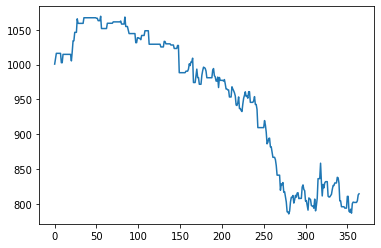

Investing Total: 741.9888314506794 -25.8%
Algo- trading Total: 814.3110707818615 -18.6%


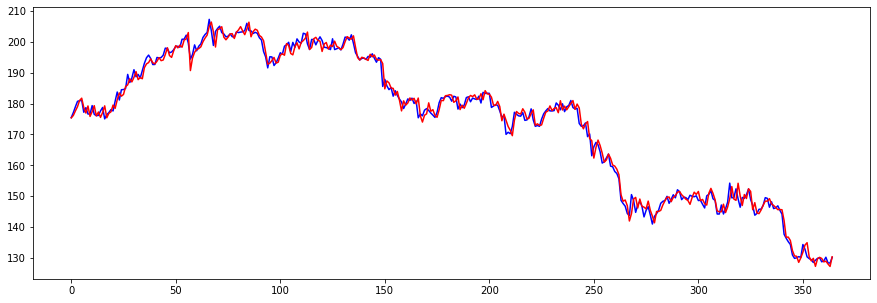

In [ ]:
from sklearn.linear_model import LinearRegression

y = history['Close']
X = history.drop(['Close','Volume'],axis=1).values

num_test = 365
X_train = X[:-1*num_test]
y_train = y[:-1*num_test]
X_test = X[-1*num_test:]
y_test = y[-1*num_test:]

#print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

model = LinearRegression()
model = model.fit(X_train,y_train)
preds = model.predict(X_test)

print(ticker)

test_it(X_test.T[0],y_test,preds,1000,0.0)
#The code is copied and executed in 8th section of Data interpretation (starting of the code) 
plt.figure(figsize=(15,5))
plt.plot(range(len(y_test)),y_test,'blue')
plt.plot(range(len(preds)),preds,'red')
plt.show()

#SP500 Data Preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import time

In [ ]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol']
print(tickers)

0       MMM
1       AOS
2       ABT
3      ABBV
4      ABMD
       ... 
498     YUM
499    ZBRA
500     ZBH
501    ZION
502     ZTS
Name: Symbol, Length: 503, dtype: object


In [ ]:
yearly_combined = pd.DataFrame()

for ticker in tickers[0:2]:
    start = time.time()
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        #display(info)
        
        balance = stock.balance_sheet
        financials = stock.financials
        earnings = stock.earnings
        cashflow = stock.cashflow
        #display(balance)
        #display(financials)
        #display(earnings)
        #display(cashflow)

        start_dates=balance.columns.values
        end_dates = start_dates + np.timedelta64(366,'D')

        start_dates = [str(date)[:-19] for date in start_dates]
        end_dates = [str(date)[:-19] for date in end_dates]
        #print(start_dates)
        year1 = stock.history(start=start_dates[0],end = end_dates[0],period='day').reset_index(drop=True)
        year2 = stock.history(start=start_dates[1],end = end_dates[1],period='day').reset_index(drop=True)
        year3 = stock.history(start=start_dates[2],end = end_dates[2],period='day').reset_index(drop=True)
        year4 = stock.history(start=start_dates[3],end = end_dates[3],period='day').reset_index(drop=True)
        #display(year4)

        columns=earnings.T.columns.values
        #print(columns)
        balance.columns = columns
        financials.columns=columns
        earnings = earnings.T
        cashflow.columns = columns
        cashflow = cashflow.drop(['Net Income'], axis=0)

        yearly= pd.concat([balance,financials, cashflow, earnings]).T
        #display(yearly)
        columns = yearly.columns.values
        #print(columns)

    #liquidity
        #current ratio = current assets/current liabilities
        yearly['current_ratio'] = yearly['Total Current Assets']/yearly['Total Current Liabilities']

        #Quick ratio = (cash + cash equivalents + temp. investments + accounts receivable) / current liabilities
        yearly['quick_ratio']= yearly['Total Current Assets']
        if 'Inventory' in columns:
            yearly['quick_ratio'] += yearly['Inventory']
        yearly['quick_ratio'] /= yearly['Total Current Liabilities']

        #Cash ratio = (cash + cash equivalents) / current liabilities
        yearly['cash_ratio']= yearly['Cash']
        if 'Short Term Investments' in columns:
            yearly['cash_ratio'] += yearly['Short Term Investments']
        yearly['cash_ratio'] /= yearly['Total Current Liabilities']

        #Operating cash flow = operating cash flow/ current liabilities
        yearly['operating_cashflow'] = yearly['Total Cash From Operating Activities'] / yearly['Total Current Liabilities']

        #Equity ratio = total equity / total assets
        yearly['equity_ratio'] = yearly['Total Stockholder Equity'] / yearly['Total Assets']

    #Leverage
        #debt to equity = total liabilities / shareholder equity
        yearly['debt_to_equity'] = yearly['Total Liab'] / yearly['Total Stockholder Equity']

        #debt to assets = total liabilities / total assets
        yearly['debt_to_assets'] = yearly['Total Liab'] / yearly['Total Assets']
        
        #interest coverage = operating income / interest expenses
        yearly['interest_coverage'] = yearly['Operating Income'] / yearly['Interest Expense']

    #efficiency
        #asset turnover = revenue/ total assets
        yearly['asset_turnover'] = yearly['Revenue'] / yearly['Total Assets']

        #RECEIVABLES TURNOVER = revenue / accounts receivables
        if 'Net Receivables' in columns:
            yearly['receivables_turnover'] = yearly['Revenue'] / yearly['Net Receivables']
        else: 
            yearly['receivables_turnover'] = np.nan
    
    
    #Profitability
        #gross margin = gross profit/revenue
        yearly['gross_margin'] =yearly['Gross Profit'] / yearly['Revenue']
        
        #profit margin = net income / revenue
        yearly['profit_margin'] =yearly['Net Income'] / yearly['Revenue']

        #operating margin = operating income / revenue
        yearly['operating_margin'] =yearly['Operating Income'] / yearly['Revenue']

        #return on equity = net income / shareholder equity
        yearly['return_on_equity'] =yearly['Net Income'] / yearly['Total Stockholder Equity']

        #return on assets =  net income / total assets
        yearly['return_on_assets'] =yearly['Net Income'] / yearly['Total Assets']
        shareprice = np.array([year4.loc[0,'Close'],year3.loc[0,'Close'],year2.loc[0,'Close'],year1.loc[0,'Close']])

        #eps = earning/total shares outstanding
        if 'Issuance of Stock' in columns:
            yearly['eps']= yearly['Earnings'] / yearly['Issuance Of Stock']
        else:
            yearly['eps'] = yearly['Earnings'] / info['sharesOutstanding']

        #p/e = share price / eps
        yearly['p/e'] = shareprice / yearly['eps']

        yearly['ticker']=ticker
        yearly['sector']=info['sector']
        yearly['year']=yearly.index.values
        #display(yearly)

        startprice=np.array([year4.loc[1,'Open'],year3.loc[1,'Open'],year2.loc[1,'Open'],year1.loc[1,'Open'] ])
        endprice=np.array([year4.loc[len(year4)-1,'Close'],year3.loc[len(year3)-1,'Close'],year2.loc[len(year2)-1,'Close'],year1.loc[len(year1)-1,'Close']])
        pctdiff = (endprice-startprice)/startprice
        yearly['result']= pctdiff
        #display(yearly)

        columns = ['ticker','year','sector','current_ratio', 'quick_ratio','cash_ratio','operating_cashflow','equity_ratio',
                   'debt_to_equity','debt_to_assets','interest_coverage','asset_turnover','receivables_turnover','gross_margin',
                   'profit_margin','operating_margin','return_on_equity','return_on_assets','eps','p/e','result']
        yearly=yearly[columns].reset_index(drop=True)

        if yearly_combined.empty:
            yearly_combined = yearly
        else:
            yearly_combined = pd.concat([yearly_combined,yearly]).reset_index(drop=True)
    except Exception as e:
        print(ticker,e)

    time_diff = time.time() - start
    if time_diff < 10:
        time.sleep(10-time_diff)

display(yearly_combined)
yearly_combined.to_csv('combined.csv',index=False)

,ticker,year,sector,current_ratio,quick_ratio,cash_ratio,operating_cashflow,equity_ratio,debt_to_equity,debt_to_assets,...,asset_turnover,receivables_turnover,gross_margin,profit_margin,operating_margin,return_on_equity,return_on_assets,eps,p/e,result
0,MMM,2018,Industrials,1.704815,2.256558,0.527393,0.825014,0.319638,2.12382,0.678854,...,0.696061,6.868973,0.505997,0.180711,0.237754,0.393527,0.125786,9.399728,17.967421,-0.029048
1,MMM,2019,Industrials,1.885003,2.418344,0.63387,1.02076,0.271777,2.674516,0.726871,...,0.678777,6.653416,0.488082,0.169561,0.222679,0.423486,0.115094,7.937665,20.363947,0.016395
2,MMM,2020,Industrials,1.406528,1.854804,0.265777,0.766645,0.22533,3.43168,0.77326,...,0.720661,6.484787,0.468307,0.140349,0.195905,0.448872,0.101144,9.575457,17.347673,0.047247
3,MMM,2021,Industrials,1.892463,2.495168,0.4463,0.888874,0.268384,2.720702,0.730192,...,0.96863,6.90123,0.455664,0.151294,0.219686,0.546039,0.146548,10.404896,16.739164,-0.255744
4,AOS,2018,Industrials,1.5665,1.966661,0.564355,0.573025,0.527343,0.8963,0.472657,...,0.91754,5.025063,0.411211,0.152797,0.191003,0.265855,0.140197,3.415977,11.723657,0.149683
5,AOS,2019,Industrials,1.825567,2.164166,0.778066,0.63421,0.584776,0.710058,0.415224,...,0.946847,5.115726,0.370301,0.115247,0.147359,0.186604,0.109121,2.845366,15.995777,0.165654
6,AOS,2020,Industrials,1.957469,2.352772,0.719374,0.595173,0.545062,0.834653,0.454938,...,0.946795,4.91145,0.407799,0.127793,0.158775,0.221982,0.120994,2.652342,20.156266,0.596277
7,AOS,2021,Industrials,2.086464,2.474468,0.821342,0.571629,0.55901,0.788876,0.44099,...,1.152173,5.467171,0.3689,0.125519,0.1555,0.258707,0.14462,3.745886,22.732212,-0.334644


In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 6.4 MB 9.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
print(columns)

['ticker', 'year', 'sector', 'current_ratio', 'quick_ratio', 'cash_ratio', 'operating_cashflow', 'equity_ratio', 'debt_to_equity', 'debt_to_assets', 'interest_coverage', 'asset_turnover', 'receivables_turnover', 'gross_margin', 'profit_margin', 'operating_margin', 'return_on_equity', 'return_on_assets', 'eps', 'p/e', 'result']


#Logistic Regression

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf

In [ ]:
data = pd.read_csv('sp500_data.csv')
data['sector']=data['sector'].astype('category')
data['sector']=data['sector'].cat.codes

data.dropna(subset=['result'],inplace=True)

#plt.hist(data['result'])

bins=[-10,0,0.25,0.5,10]
data['result_bin'] = pd.cut(data['result'],bins).astype('category').cat.codes

pct_change = data['result']

data = data.drop(['result'],axis=1)
#display(data)
X = data[data.columns[2:-1]]
y = data['result_bin']
#display(data.isna().sum())
#display(data['result_bin'])

train_idx = data[data['year']<2020].index.values
test_idx = data[data['year']==2020].index.values

X_train = X.loc[train_idx]
X_test = X.loc[test_idx]
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

IQR = X_train.quantile(.75) - X_train.quantile(.25)
lower = X_train.quantile(.25) - 1.5*IQR
upper = X_train.quantile(.75) + 1.5*IQR

for i in X_train.columns:
    X_train.loc[X_train[i]<lower[i],i]= lower[i]
    X_train.loc[X_train[i]>upper[i],i]= upper[i]

    X_test.loc[X_test[i]<lower[i],i]= lower[i]
    X_test.loc[X_test[i]>upper[i],i]= upper[i]

    X_test[i].fillna(X_train[i].median(),inplace=True) #filling missing values
    X_train[i].fillna(X_train[i].median(),inplace=True)

    X_test[i] = (X_test[i] - X_train[i].min())/(X_train[i].max()-X_train[i].min())
    X_train[i] = (X_train[i] - X_train[i].min())/(X_train[i].max()-X_train[i].min())

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1267, 18) (476, 18) (1267,) (476,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [ ]:
model = LogisticRegression(max_iter=1000)
model = model.fit(X_train,y_train)
preds = model.predict(X_test)

print("accuracy Score: ",accuracy_score(preds,y_test))

print(preds)
#print(y_test.values)

print(pct_change[test_idx].mean())
print(pct_change[y_test[preds>0].index.values].mean())
print(pct_change[y_test[preds>2].index.values].mean()) #10% more returns

accuracy Score:  0.2184873949579832
[1 1 0 1 3 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 2 0 0 1 1 1 1 0 0 1 0 0
 1 0 1 1 1 0 0 1 1 1 3 0 2 1 1 1 1 0 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0
 1 1 1 0 0 0 1 0 2 0 1 0 1 1 0 1 0 0 2 0 1 0 0 0 0 0 1 0 0 1 1 0 2 0 1 2 0
 0 1 1 1 0 0 2 1 2 1 2 0 1 0 1 1 1 1 3 1 1 0 0 1 0 0 0 2 1 2 0 0 0 2 1 0 1
 1 1 1 1 0 1 1 1 0 2 0 1 0 1 1 0 2 1 1 0 1 1 1 3 0 1 1 1 0 1 1 1 1 1 1 0 2
 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 3 0 0 1 1 0 2 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1
 2 0 1 0 1 3 0 1 0 1 2 1 1 1 1 0 0 1 2 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 3
 1 1 0 1 1 1 1 1 1 1 2 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 2 2 1 0 1 1 0 0 2 0 0
 0 2 0 1 2 0 1 1 1 0 0 2 1 3 2 1 0 0 1 0 1 1 0 2 0 0 1 0 1 1 1 1 0 0 0 2 1
 1 3 1 1 1 0 0 0 1 1 1 0 1 1 0 2 1 2 0 2 1 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0
 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 2 1 1 1 0 1 1 0 0 0 0 1 3 0 3 0 2 0 1
 0 0 2 1 1 0 3 0 2 1 2 0 3 0 3 0 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 2 0 1 0 0 0 0 0 2 1 1 1 0 2 0 1